# Sanitizing BC2013 with trained Tactoron2 on BC2013

**Principle**
- Teacher forcing results give some clues to find whether text-audio pairs are well matched.
- If the pair is completely mismatched, the attention alignment graph show nothing disappears.
  - This can be found out by the **attention quality**.
- With this attention alignment, we can find audios full scripts of which are not spoken.

In [1]:
import os
cwd_old = os.getcwd()
os.chdir('..')
cwd_new = os.getcwd()
print("The working directory is moved from {} to {}.".format(cwd_old, cwd_new))

The working directory is moved from /data2/sungjaecho/Projects/tacotron2/dev_ipynb to /data2/sungjaecho/Projects/tacotron2.


In [9]:
import pandas as pd
from g2p_en import G2p
from text import _clean_text
from tqdm import tqdm

In [3]:
from text import cmudict
def get_p_range_len(p_seq):
    n_nonphones = 0 
    for p_symbol in p_seq:
        if p_symbol in cmudict.valid_symbols:
            break
        else:
            n_nonphones += 1
    for p_symbol in reversed(p_seq):
        if p_symbol in cmudict.valid_symbols:
            break
        else:
            n_nonphones += 1
    phone_range_len = len(p_seq) - n_nonphones
    
    return phone_range_len

# 1. Import BC2013 metatdata: `bc2013_att_measures.csv` and `bc2013.csv`

In [4]:
csv_path = 'metadata/bc2013_v1_att_measures.csv'
df = pd.read_csv(csv_path)
df_bc = pd.read_csv('metadata/bc2013_v1.csv')
df = df.join(df_bc.set_index('wav_path'), on='wav_path')

In [5]:
df.head()

,wav_path,aq,far,ar,letter_ar,punct_ar,blank_ar,arr,mar,database,...,duration,text,speaker,sex,emotion,lang,segmented,book,chapter,sentence_id
0,/data2/sungjaecho/data_tts/BC2013/segments/per...,0.859909,0.984932,0.909774,0.921569,0.00,0.964286,0.984962,0.052632,bc2013,...,8.480,but the ten minutes only which now passed befo...,bc2013-w,w,neutral,en,False,persuasion,23.0,194.0
1,/data2/sungjaecho/data_tts/BC2013/segments/emm...,0.857064,0.979560,0.905172,0.939759,0.25,0.896552,1.000000,0.068966,bc2013,...,7.388,and it is natural to suppose that we should be...,bc2013-w,w,neutral,en,False,emma,24.0,163.0
2,/data2/sungjaecho/data_tts/BC2013/segments/pri...,0.865889,0.983580,0.827586,0.920000,0.00,0.771429,1.000000,0.043103,bc2013,...,7.075,"I have, therefore, made up my mind to tell you...",bc2013-w,w,neutral,en,False,pride_and_prejudice,10.0,111.0
3,/data2/sungjaecho/data_tts/BC2013/segments/the...,0.872263,0.989181,0.878261,0.913580,0.25,0.866667,0.982609,0.034783,bc2013,...,7.519,"And saintly men, who walk with God on earth, w...",bc2013-w,w,neutral,en,False,the_scarlet_letter,10.0,58.0
4,/data2/sungjaecho/data_tts/BC2013/segments/bla...,0.804223,0.975610,0.871287,0.885714,0.50,0.888889,1.000000,0.069307,bc2013,...,7.623,"'Poor lassie! it was a bad business, a bad bus...",bc2013-w,w,neutral,en,False,black_beauty,7.0,62.0


# 2. Find audios full scripts of which are not spoken

## 2.1. Find them

In [7]:
g2p = G2p()

In [13]:
i_rm_list = list()
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = _clean_text(row.text, ['english_cleaners'])
    phones = g2p(text)
    phones = [' '] + phones + [' ']
    p_range_len = get_p_range_len(phones)
    
    p_range_len_arr = row.arr * len(phones)
    if p_range_len > p_range_len_arr and :
        i_rm_list.append(i)

100%|██████████| 88111/88111 [21:13<00:00, 69.17it/s]  


In [14]:
print(len(df))
print(len(i_rm_list))
print(len(df) - len(i_rm_list))

88111
1003
87108


## 2.2. Delete them

In [26]:
df_original = df

In [28]:
df = df_original.drop(i_rm_list)
df = df.reset_index(drop=True)

In [31]:
print(len(df_original))
print(len(df))

88111
87108


# 3. Leave out low audios with letter attention ratio

# 3.1. Exploration

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fadc3efae50>]],
      dtype=object)

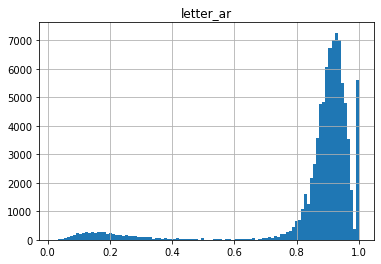

In [34]:
df.hist(column=['letter_ar'], bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fadc3d5a450>]],
      dtype=object)

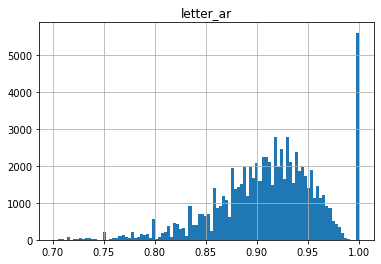

In [36]:
df[df.letter_ar > 0.7].hist(column=['letter_ar'], bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fadc3bf2a10>]],
      dtype=object)

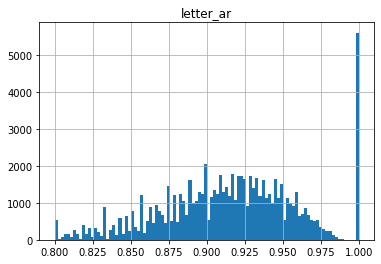

In [37]:
df[df.letter_ar > 0.8].hist(column=['letter_ar'], bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fadbf227a90>]],
      dtype=object)

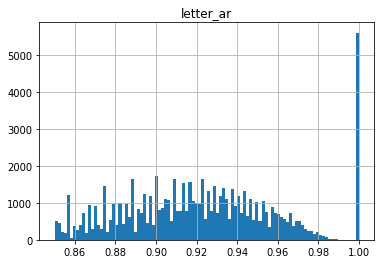

In [45]:
df[df.letter_ar > 0.85].hist(column=['letter_ar'], bins=100)

In [38]:
len(df[df.letter_ar == 1.0])

5598

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fadbf215f90>]],
      dtype=object)

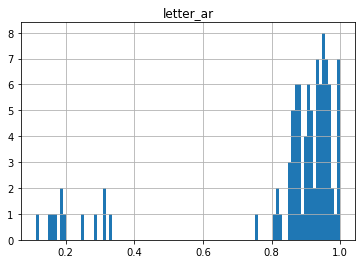

In [39]:
df[df.split=='val'].hist(column=['letter_ar'], bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fadbf10c3d0>]],
      dtype=object)

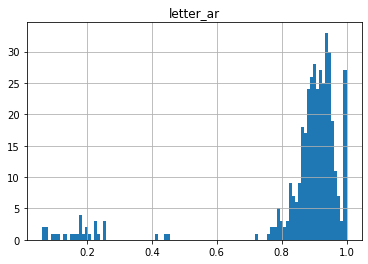

In [40]:
df[df.split=='test'].hist(column=['letter_ar'], bins=100)

In [78]:
duration = df[df.letter_ar <= 0.6].duration.sum()
h, m, s = duration // (60*60),  (duration % (60*60)) // 60, duration % 60
print((h,m,s))
h, m, s = (df.duration.sum()-duration) // (60*60),  (duration % (60*60)) // 60, duration % 60
print((h,m,s))
print(duration / df.duration.sum())

(7.0, 0.0, 35.14300000000367)
(93.0, 0.0, 35.14300000000367)
0.0698709110461458


In [77]:
duration = df[df.letter_ar <= 0.8].duration.sum()
h, m, s = duration // (60*60),  (duration % (60*60)) // 60, duration % 60
print((h,m,s))
h, m, s = (df.duration.sum()-duration) // (60*60),  (duration % (60*60)) // 60, duration % 60
print((h,m,s))
print(duration / df.duration.sum())

(8.0, 30.0, 6.224000000001979)
(91.0, 30.0, 6.224000000001979)
0.08474232757715748


In [79]:
duration = df[df.letter_ar <= 0.85].duration.sum()
h, m, s = duration // (60*60),  (duration % (60*60)) // 60, duration % 60
print((h,m,s))
h, m, s = (df.duration.sum()-duration) // (60*60),  (duration % (60*60)) // 60, duration % 60
print((h,m,s))
print(duration / df.duration.sum())

(14.0, 32.0, 51.57600000000093)
(85.0, 32.0, 51.57600000000093)
0.14500610232493885


In [46]:
import IPython.display as ipd

In [47]:
df.columns

Index(['wav_path', 'aq', 'far', 'ar', 'letter_ar', 'punct_ar', 'blank_ar',
       'arr', 'mar', 'database', 'split', 'duration', 'text', 'speaker', 'sex',
       'emotion', 'lang', 'segmented', 'book', 'chapter', 'sentence_id'],
      dtype='object')

## 3.2. Listening

In [ ]:
# 0.8 is a good threhold. 
# I've listened to Audios sorted by asceding letter_ar
# Most of them have good quality.
letter_ar_min = 0.8
df_check = df[df.letter_ar > letter_ar_min].sort_values(by='letter_ar', ascending=True).reset_index(drop=True)

for i, row in df_check.iterrows():
    if i < 50 and i >= 40:
        text = _clean_text(row.text, ['english_cleaners'])
        phones = g2p(text)
        phones = [' '] + phones + [' ']
        p_range_len = get_p_range_len(phones)

        p_range_len_arr = row.arr * len(phones)
        unspoken_p_len = (p_range_len - p_range_len_arr)

        print("Script:", row.text)
        print("AQ:", row.aq)
        print("LAR:", row.letter_ar)
        print("ARR:", row.arr)
        print("MAR:", row.mar)
        print("p_range_len", p_range_len)
        print("p_range_len_arr:", p_range_len_arr)
        print("len(phones)", len(phones))
        print("split", row.split)
        ipd.display(ipd.Audio(row.wav_path))
    if i == 50:
        break

## 3.3. Leave audios of good quality

In [106]:
letter_ar_min = 0.8
df2 = df[df.letter_ar > letter_ar_min].reset_index(drop=True)

# 4. Save it to be used

In [107]:
duration = df2.duration.sum()
h, m, s = duration // (60*60),  (duration % (60*60)) // 60, duration % 60
print((h, m, s))

(91.0, 49.0, 21.859000000054948)


In [108]:
print(df2.shape)
df2 = df2[df_bc.columns]
print(df2.shape)

(78956, 21)
(78956, 13)


In [110]:
import random
random.seed(1234)
split_list = ['val'] * 100 + ['test'] * 400 + ['train'] * (len(df2) - 100 - 400)
random.shuffle(split_list)

df2.loc[:,'split'] = split_list

print(df2[df2.split == 'val'].shape)
print(df2[df2.split == 'test'].shape)
print(df2[df2.split == 'train'].shape)

(100, 13)
(400, 13)
(78456, 13)


In [111]:
df2.to_csv('metadata/bc2013_v2.csv', index=False)
df2[df2.split == 'train'].to_csv('metadata/bc2013_v2_train.csv', index=False)
df2[df2.split == 'val'].to_csv('metadata/bc2013_v2_val.csv', index=False)
df2[df2.split == 'test'].to_csv('metadata/bc2013_v2_test.csv', index=False)

In [112]:
df2.to_csv('metadata/bc2013.csv', index=False)
df2[df2.split == 'train'].to_csv('metadata/bc2013_train.csv', index=False)
df2[df2.split == 'val'].to_csv('metadata/bc2013_val.csv', index=False)
df2[df2.split == 'test'].to_csv('metadata/bc2013_test.csv', index=False)

In [114]:
from metadata import MetaData, convert_sec

db = "bc2013"
md = MetaData(db)
md.print_data_stat()

bc2013
       wav_path    duration
split                      
test        400    1554.128
train     78456  328609.053
val         100     398.678
                        wav_path    duration
split speaker  emotion                      
test  bc2013-w neutral       400    1554.128
train bc2013-w neutral     78456  328609.053
val   bc2013-w neutral       100     398.678


In [117]:
print(convert_sec(1554.128))
print(convert_sec(328609.053))
print(convert_sec(398.678))

(0.0, 25.0, 54.12799999999993)
(91.0, 16.0, 49.053000000014435)
(0.0, 6.0, 38.678)
